In [1]:
import torch
import numpy as np
import random
import os

# 손실 함수(Loss Function)

## 회귀에서의 손실함수

- MSE

In [2]:
torch.nn.MSELoss()

MSELoss()

- MAE

In [3]:
torch.nn.L1Loss()

L1Loss()

## 분류에서의 손실함수

- CE(Cross Entropy)
    - 다중분류에서 사용

In [4]:
torch.nn.CrossEntropyLoss()

CrossEntropyLoss()

- BCE(Binary Cross Entropy)
    - 이진 분류에서 사용

In [5]:
torch.nn.BCEWithLogitsLoss()

BCEWithLogitsLoss()

In [7]:
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 재현성 함수

In [9]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
reset_seeds(SEED)

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
DATA_PATH = "/content/drive/MyDrive/data/"

In [15]:
# 아래 복붙
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
df = pd.read_csv(f"{DATA_PATH}titanic.csv")
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.fare = df.fare.fillna(df.fare.median()) # fare 중앙값
df.cabin = df.cabin.fillna("UNK") # cabin 임의의 문자열로 채우기
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값
# 학습에 바로 사용가능한 특성
cols = ["pclass","age","sibsp","parch","fare"]
features = df[cols]
# 범주형 one-hot encoding
cols = ["gender","embarked"]
enc = OneHotEncoder()
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
features = pd.concat([features,tmp],axis=1) # 특성
target = df["survived"].to_numpy() # 정답값
# 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
# 학습 검증 나누기
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(features, target, random_state=SEED)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((981, 10), (328, 10), (981,), (328,))

In [16]:
class TitanicDataset(torch.utils.data.Dataset):
    def __init__(self, x, y = None):
        self.x = x  
        self.y = y
        if self.y is not None:
            self.y = y.reshape(-1,1)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        item = {}
        item["x"] = torch.Tensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item

In [20]:
train_dt = TitanicDataset(x_train,y_train)
train_dl = torch.utils.data.DataLoader(train_dt,batch_size=2,shuffle=False)

In [21]:
next(iter(train_dl))

{'x': tensor([[0.5000, 0.3611, 0.1250, 0.0000, 0.0507, 1.0000, 0.0000, 0.0000, 0.0000,
          1.0000],
         [1.0000, 0.5365, 0.1250, 0.6667, 0.0915, 1.0000, 0.0000, 0.0000, 0.0000,
          1.0000]]), 'y': tensor([[1.],
         [0.]])}

In [28]:
reset_seeds(SEED)

input_layer = torch.nn.Linear(x_train.shape[1],8)

data = next(iter(train_dl))
hidden_layer = input_layer(data["x"])
hidden_layer

tensor([[-0.1286,  0.0161, -0.4053,  0.0390, -0.1016, -0.3951, -0.1245, -0.0280],
        [ 0.2292,  0.1987, -0.3550,  0.1655,  0.1215, -0.3963, -0.2210, -0.0540]],
       grad_fn=<AddmmBackward0>)

# 활성화 함수

## 시그모이드 함수(Sigmoid)
- 0~1 사이에 값을 갖는 함수

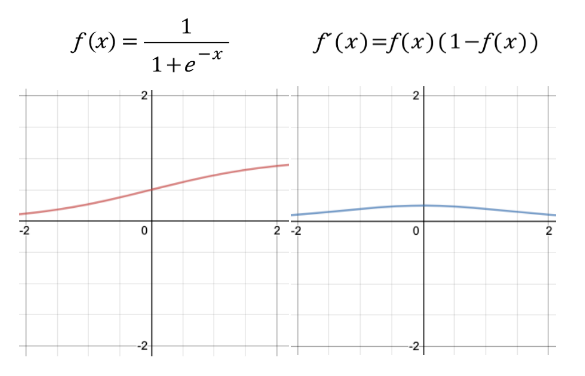

In [29]:
hidden_layer

tensor([[-0.1286,  0.0161, -0.4053,  0.0390, -0.1016, -0.3951, -0.1245, -0.0280],
        [ 0.2292,  0.1987, -0.3550,  0.1655,  0.1215, -0.3963, -0.2210, -0.0540]],
       grad_fn=<AddmmBackward0>)

In [30]:
sig = torch.nn.Sigmoid()
sig(hidden_layer)

tensor([[0.4679, 0.5040, 0.4000, 0.5097, 0.4746, 0.4025, 0.4689, 0.4930],
        [0.5570, 0.5495, 0.4122, 0.5413, 0.5303, 0.4022, 0.4450, 0.4865]],
       grad_fn=<SigmoidBackward0>)

## 탄젠트 함수(Hyperbolic Tangent)
- -1 ~ 1 사이의 값을 갖는 함수

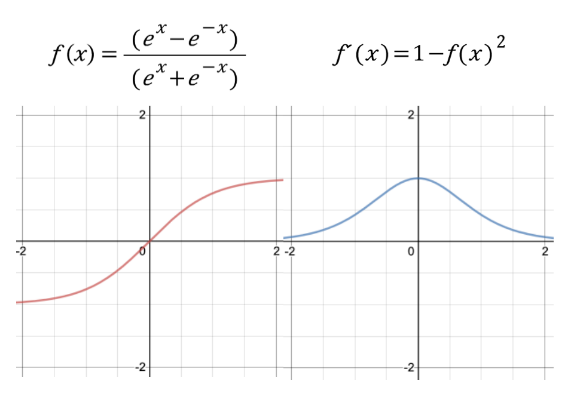

In [31]:
tanh = torch.nn.Tanh()
tanh(hidden_layer)

tensor([[-0.1279,  0.0161, -0.3845,  0.0389, -0.1013, -0.3757, -0.1238, -0.0279],
        [ 0.2252,  0.1961, -0.3408,  0.1640,  0.1209, -0.3768, -0.2175, -0.0540]],
       grad_fn=<TanhBackward0>)

## ReLU
- 입력이 0이상이면 그대로 출력, 음수이면 0으로 출력

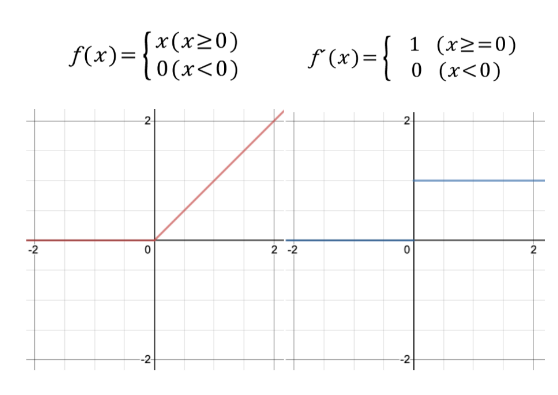

In [35]:
hidden_layer

tensor([[-0.1286,  0.0161, -0.4053,  0.0390, -0.1016, -0.3951, -0.1245, -0.0280],
        [ 0.2292,  0.1987, -0.3550,  0.1655,  0.1215, -0.3963, -0.2210, -0.0540]],
       grad_fn=<AddmmBackward0>)

In [34]:
relu = torch.nn.ReLU()
relu(hidden_layer)

tensor([[0.0000, 0.0161, 0.0000, 0.0390, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2292, 0.1987, 0.0000, 0.1655, 0.1215, 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

## LeakyReLU
- ReLU의 변형된 함수
- Dying ReLU 현상을 해결하기 위해서 나온 함수

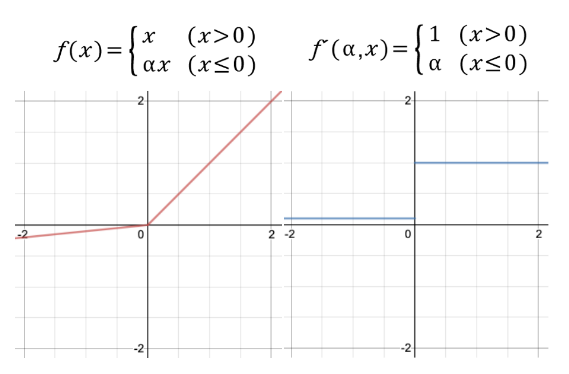

In [37]:
lk_relu = torch.nn.LeakyReLU()
lk_relu(hidden_layer)

tensor([[-0.0013,  0.0161, -0.0041,  0.0390, -0.0010, -0.0040, -0.0012, -0.0003],
        [ 0.2292,  0.1987, -0.0035,  0.1655,  0.1215, -0.0040, -0.0022, -0.0005]],
       grad_fn=<LeakyReluBackward0>)

## PReLU(Parametric ReLU)
- Leaky ReLU와 유사하지만 음수에 곱하는 알파값을 학습을 통해 업데이트

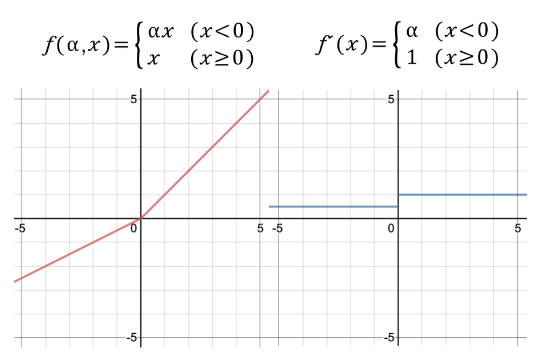

In [38]:
p_relu = torch.nn.PReLU()
p_relu(hidden_layer)

tensor([[-0.0321,  0.0161, -0.1013,  0.0390, -0.0254, -0.0988, -0.0311, -0.0070],
        [ 0.2292,  0.1987, -0.0887,  0.1655,  0.1215, -0.0991, -0.0553, -0.0135]],
       grad_fn=<PreluBackward0>)

## ELU(Exponential Linear Unit)
- 입력이 음수일경우 지수함수를 이용해서 부드럽게 깍아준다.
- ReLU계열의 모든 장점포함

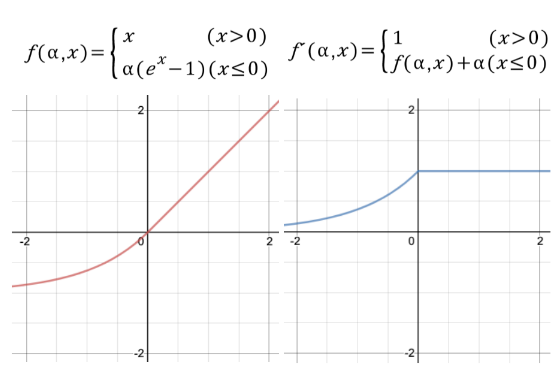

In [39]:
elu = torch.nn.ELU()
elu(hidden_layer)

tensor([[-0.1207,  0.0161, -0.3332,  0.0390, -0.0966, -0.3264, -0.1170, -0.0276],
        [ 0.2292,  0.1987, -0.2988,  0.1655,  0.1215, -0.3272, -0.1983, -0.0526]],
       grad_fn=<EluBackward0>)

## 소프트맥스 함수(Softmax)
- 입력받은 값들을 0~1사이에 값들로 정규화 하여 총합이 1이 되게 해서 출력하는 함수

In [45]:
softmax = torch.nn.Softmax(dim=1)
softmax(hidden_layer)

tensor([[0.1250, 0.1445, 0.0948, 0.1478, 0.1284, 0.0958, 0.1255, 0.1382],
        [0.1590, 0.1542, 0.0886, 0.1492, 0.1428, 0.0851, 0.1014, 0.1198]],
       grad_fn=<SoftmaxBackward0>)

# 배치 정규화
- 배치 단위로 평균과 분산을 이용해서 정규화

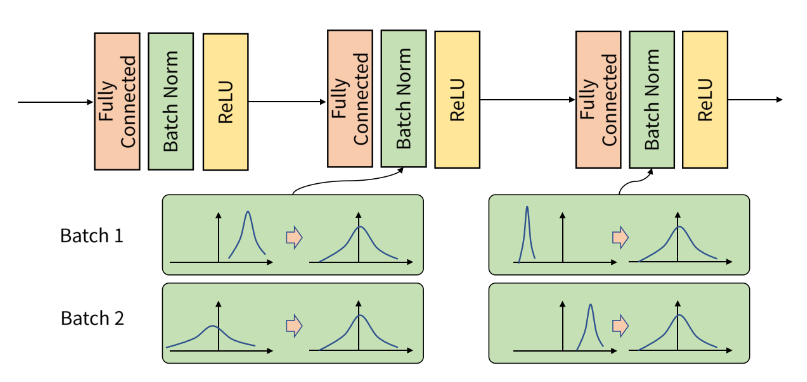

In [46]:
hidden_layer

tensor([[-0.1286,  0.0161, -0.4053,  0.0390, -0.1016, -0.3951, -0.1245, -0.0280],
        [ 0.2292,  0.1987, -0.3550,  0.1655,  0.1215, -0.3963, -0.2210, -0.0540]],
       grad_fn=<AddmmBackward0>)

In [48]:
bn = torch.nn.BatchNorm1d(hidden_layer.shape[1])
bn(hidden_layer)

tensor([[-0.9998, -0.9994, -0.9922, -0.9988, -0.9996,  0.1931,  0.9979,  0.9718],
        [ 0.9998,  0.9994,  0.9922,  0.9988,  0.9996, -0.1931, -0.9979, -0.9718]],
       grad_fn=<NativeBatchNormBackward0>)

In [49]:
bn(hidden_layer).mean() , bn(hidden_layer).var()

(tensor(2.0303e-07, grad_fn=<MeanBackward0>),
 tensor(0.9276, grad_fn=<VarBackward0>))

# Dropout
- 신경망에서 은닉층에 출력을 무작위로 0으로 대체
- 장점
    - 빠른 학습(계산 비용 감소)
    - 과대적합 방지

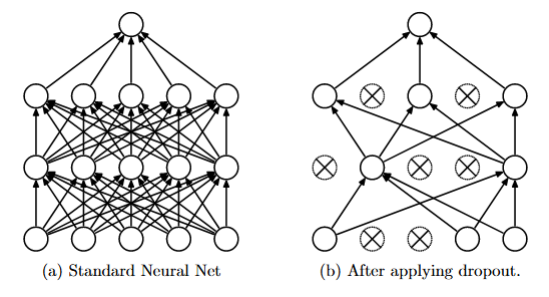

In [51]:
dropout = torch.nn.Dropout(0.2)
dropout(hidden_layer)

tensor([[-0.1607,  0.0202, -0.5066,  0.0000, -0.0000, -0.4938, -0.1556, -0.0000],
        [ 0.2864,  0.2484, -0.0000,  0.0000,  0.0000, -0.0000, -0.2763, -0.0675]],
       grad_fn=<MulBackward0>)

# torch.nn.Sequential
- 텐서가 각 Layer 에 순차적으로 통과할때 사용

In [52]:
torch.nn.Sequential(
    torch.nn.Linear(x_train.shape[1],8),
    torch.nn.ReLU(),
    torch.nn.Linear(8,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
)

Sequential(
  (0): Linear(in_features=10, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

- 신경망 모델 만들기

In [53]:
class Net(torch.nn.Module):
    def __init__(self,in_features):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(in_features,8),
            torch.nn.ReLU(),
            torch.nn.Linear(8,4),
            torch.nn.ReLU(),
            torch.nn.Linear(4,1),
        )
    def forward(self,x):
        x = self.seq(x)
        return x

In [54]:
model = Net(x_train.shape[1])

# 모델 구조 보기

## torchsummary
- 첫번째 인수에 모델 객체 전달
- input_size : 피쳐 개수 전달(튜플형태)

In [57]:
import torchsummary
torchsummary.summary(model,input_size = (x_train.shape[1],),device='cpu' )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              88
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 4]              36
              ReLU-4                    [-1, 4]               0
            Linear-5                    [-1, 1]               5
Total params: 129
Trainable params: 129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## torchinfo
- 첫번째 인수에 모델 객체전달
- 두번째 인수에 배치사이즈와 피쳐개수를 튜플로 전달

In [58]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import torchinfo
torchinfo.summary(model,(32,x_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Linear: 2-1                       [32, 8]                   88
│    └─ReLU: 2-2                         [32, 8]                   --
│    └─Linear: 2-3                       [32, 4]                   36
│    └─ReLU: 2-4                         [32, 4]                   --
│    └─Linear: 2-5                       [32, 1]                   5
Total params: 129
Trainable params: 129
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

- 학습 loop 함수화

- 검증평가 뿐만 아니라 테스트데이터에 대한 예측 loop 함수화